In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

In [2]:
# seq file path
auxiliary_files_path = '/lmh_data/data/sclab/source/frontal_cortex'
CTCF_path = os.path.join(auxiliary_files_path, 'impute_BSS00371_CTCF.bigWig')
POLR2A_path = os.path.join(auxiliary_files_path, 'impute_BSS00371_POLR2A.bigWig')
EP300_path = os.path.join(auxiliary_files_path, 'impute_BSS00371_EP300.bigWig')

H3K27ac_path = os.path.join(auxiliary_files_path, 'impute_BSS00371_H3K27ac.bigWig')
H3K4me3_path = os.path.join(auxiliary_files_path, 'impute_BSS00371_H3K4me3.bigWig')

In [3]:
pseudo_time = ['Early(MBP)', 'Late(MBP)']
pseudo_time_3D = dict()

for _dir in pseudo_time:
    file_path = None
    for root, _, files in os.walk('./{}'.format(_dir), topdown=False):
        for file_name in files:
            if file_name.split('.')[-1] == 'pdb':
                file_path = os.path.join(root, file_name)
                break

    with open(file_path, 'r') as f:
        _datas = f.readlines()[1:]
        _datas = [_data for _data in _datas if _data.startswith('ATOM')]
        _datas = [_data.split()[5:8] for _data in _datas]
        pseudo_time_3D[_dir] = np.array(_datas).astype('float')

pseudo_time_3D

{'Early(MBP)': array([[ 0.45 ,  4.424, -6.547],
        [ 2.322,  0.678, -5.791],
        [-2.694,  3.587, -2.424],
        [-5.839,  0.971, -3.657],
        [-5.068, -3.332,  1.339],
        [-1.361, -5.995,  7.057],
        [-5.052,  0.052,  3.733],
        [-3.14 ,  4.437,  1.688],
        [ 1.15 ,  6.704,  3.245],
        [ 0.913,  0.694,  6.205],
        [ 2.437, -3.792,  2.697],
        [ 6.957, -0.075,  3.118],
        [ 5.939,  3.072, -0.114],
        [ 3.245, -5.721, -1.936],
        [ 5.325, -2.555, -2.752],
        [-3.022, -6.173, -2.351],
        [-1.774, -3.846, -5.435]]),
 'Late(MBP)': array([[-1.163, -3.481, -5.857],
        [-2.357,  2.366, -6.008],
        [ 2.22 ,  3.785, -4.675],
        [ 3.189, -3.151, -4.057],
        [ 3.046,  3.075,  3.874],
        [ 1.741,  7.156,  3.4  ],
        [ 5.963,  2.152,  1.683],
        [ 5.466,  0.833, -2.949],
        [ 4.926, -6.673,  0.267],
        [ 3.231, -3.   ,  4.622],
        [-1.671, -3.253,  2.66 ],
        [-2.936,  6

In [4]:
def rotate(points1, points2):
    if (points1 == points2).all():
        return points1
    # 求解协方差矩阵C
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    demeaned1 = points1 - centroid1
    demeaned2 = points2 - centroid2
    C = np.dot(demeaned1.T, demeaned2)

    # 使用SVD分解C得到旋转矩阵R
    U, S, Vt = np.linalg.svd(C)
    R = np.dot(U, Vt)
    
    points_rotated = np.dot(points2, R)
    return points_rotated

for i in pseudo_time:
    pseudo_time_3D[i] = rotate(pseudo_time_3D[pseudo_time[0]], pseudo_time_3D[i])

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

def show(points, scores, title):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (6, 6),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', linewidth=5)
    scatter = ax.scatter(
        points[:, 0], points[:, 1], points[:, 2],
        c=scores, cmap=truncate_colormap(plt.get_cmap("Reds"), 0, 1), s=very_large*10
    )

    origin = [min(points[:, 0]), min(points[:, 1]), min(points[:, 2])]
    ax.plot([origin[0], origin[0]+1], [origin[1], origin[1]], [origin[2], origin[2]], '-', color='red')
    ax.plot([origin[0], origin[0]], [origin[1], origin[1]+1], [origin[2], origin[2]], '-', color='blue')
    ax.plot([origin[0], origin[0]], [origin[1], origin[1]], [origin[2], origin[2]+1], '-', color='green')
    
    fig.colorbar(scatter, ax=ax, fraction=0.02)
    ax.grid(False)
    ax.axis("off")

    plt.savefig('/lmh_data/work/SEE/analyse/figure_file/3D/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

In [6]:
import pyBigWig

_chr, _start, _end = 'chr18', 74690000, 74850000

def get_seq_score(chip_seq_path, _chr, _start, _end):
    bw = pyBigWig.open(chip_seq_path)
    length = 10000
    _start, _end = int(int(_start/length)*length), int(int(_end/length)*length)
    scores = []
    
    while _start <= _end:
        scores.append(bw.stats(_chr, _start, _start+length)[0])
        _start += length
    scores = np.array(scores)

    bw.close()
    return scores/max(scores)

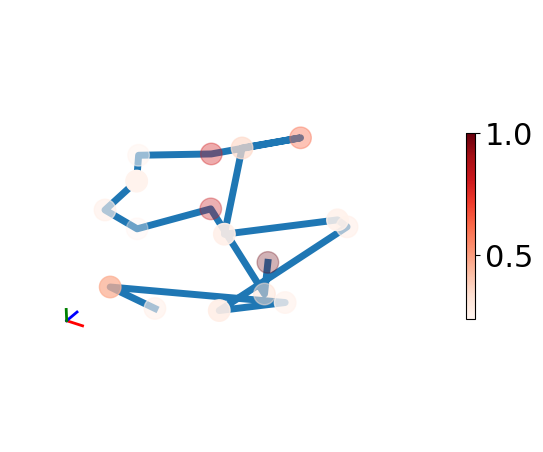

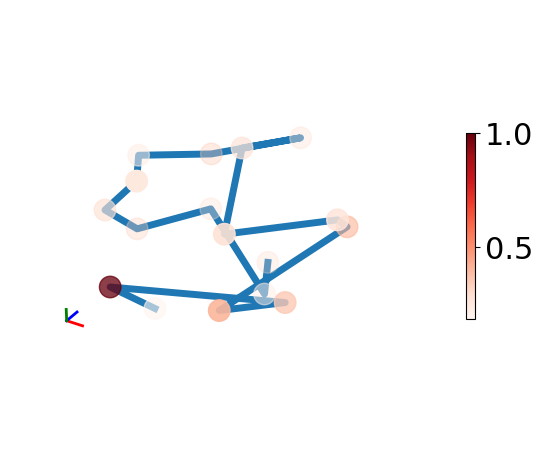

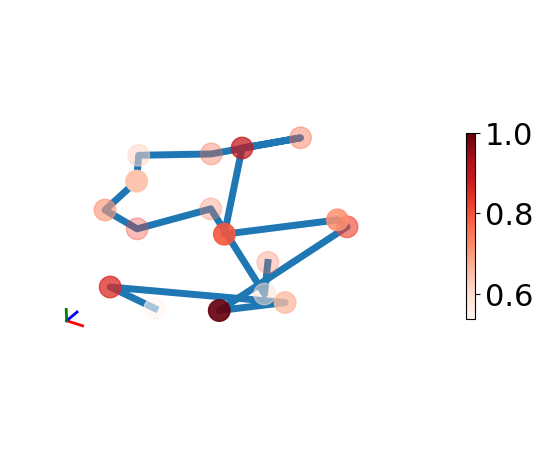

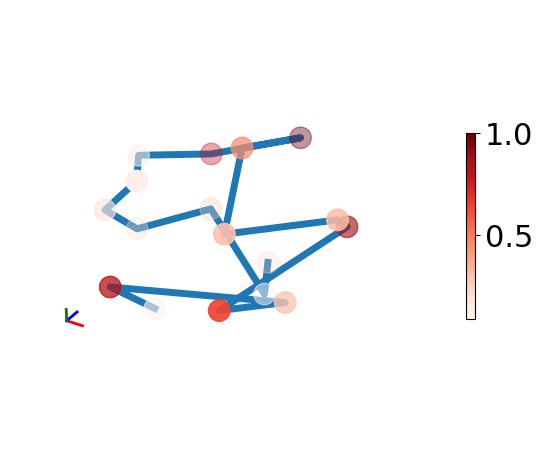

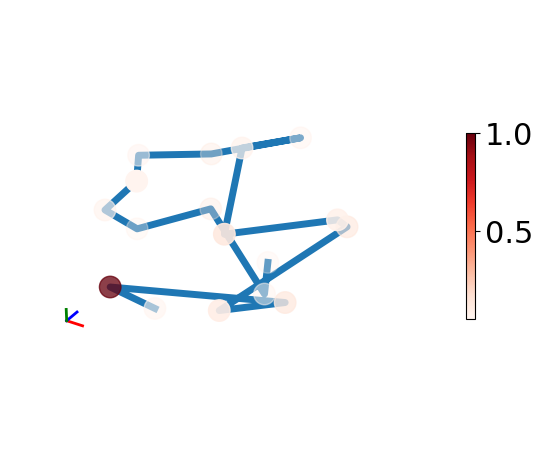

In [7]:
show(pseudo_time_3D['Early(MBP)'], get_seq_score(CTCF_path, _chr, _start, _end), 'Early(CTCF)')
show(pseudo_time_3D['Early(MBP)'], get_seq_score(POLR2A_path, _chr, _start, _end), 'Early(POLR2A)')
show(pseudo_time_3D['Early(MBP)'], get_seq_score(EP300_path, _chr, _start, _end), 'Early(EP300)')
show(pseudo_time_3D['Early(MBP)'], get_seq_score(H3K27ac_path, _chr, _start, _end), 'Early(H3K27ac)')
show(pseudo_time_3D['Early(MBP)'], get_seq_score(H3K4me3_path, _chr, _start, _end), 'Early(H3K4me3)')

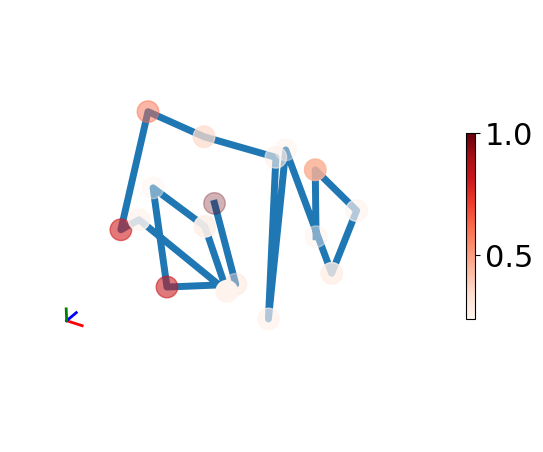

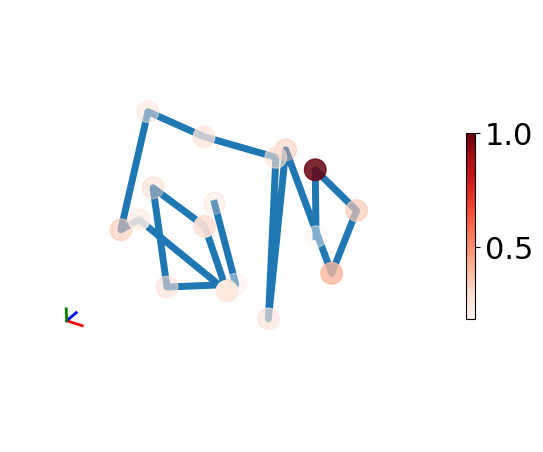

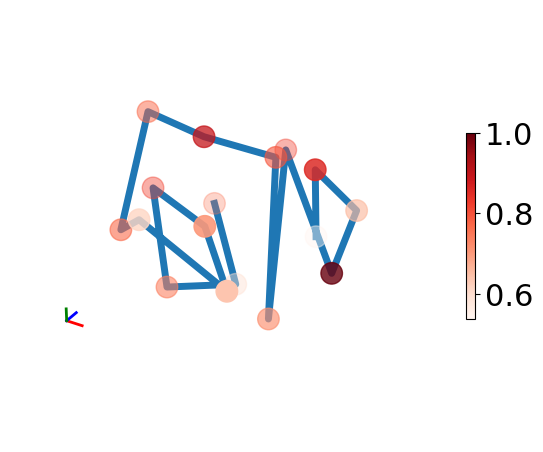

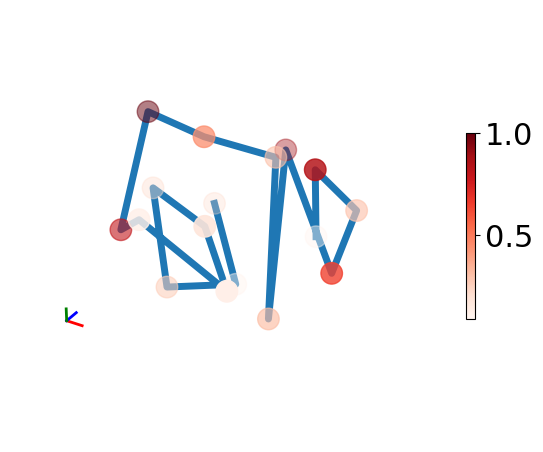

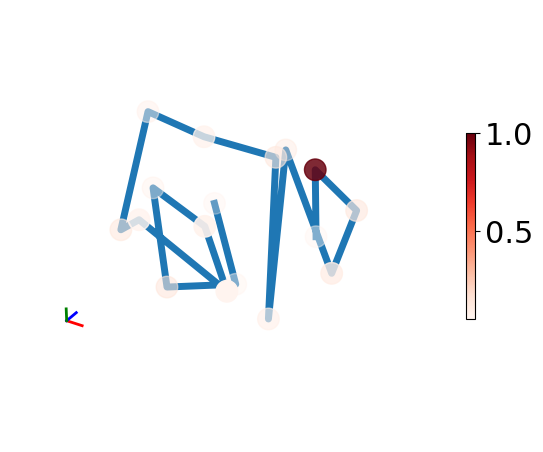

In [8]:
show(pseudo_time_3D['Late(MBP)'], get_seq_score(CTCF_path, _chr, _start, _end), 'Late(CTCF)')
show(pseudo_time_3D['Late(MBP)'], get_seq_score(POLR2A_path, _chr, _start, _end), 'Late(POLR2A)')
show(pseudo_time_3D['Late(MBP)'], get_seq_score(EP300_path, _chr, _start, _end), 'Late(EP300)')
show(pseudo_time_3D['Late(MBP)'], get_seq_score(H3K27ac_path, _chr, _start, _end), 'Late(H3K27ac)')
show(pseudo_time_3D['Late(MBP)'], get_seq_score(H3K4me3_path, _chr, _start, _end), 'Late(H3K4me3)')

In [9]:
def centrifugal_distance(points):
    _center = np.mean(points, axis=0)
    result = []
    for point in points:
        result.append(np.linalg.norm(point - _center))
    return result

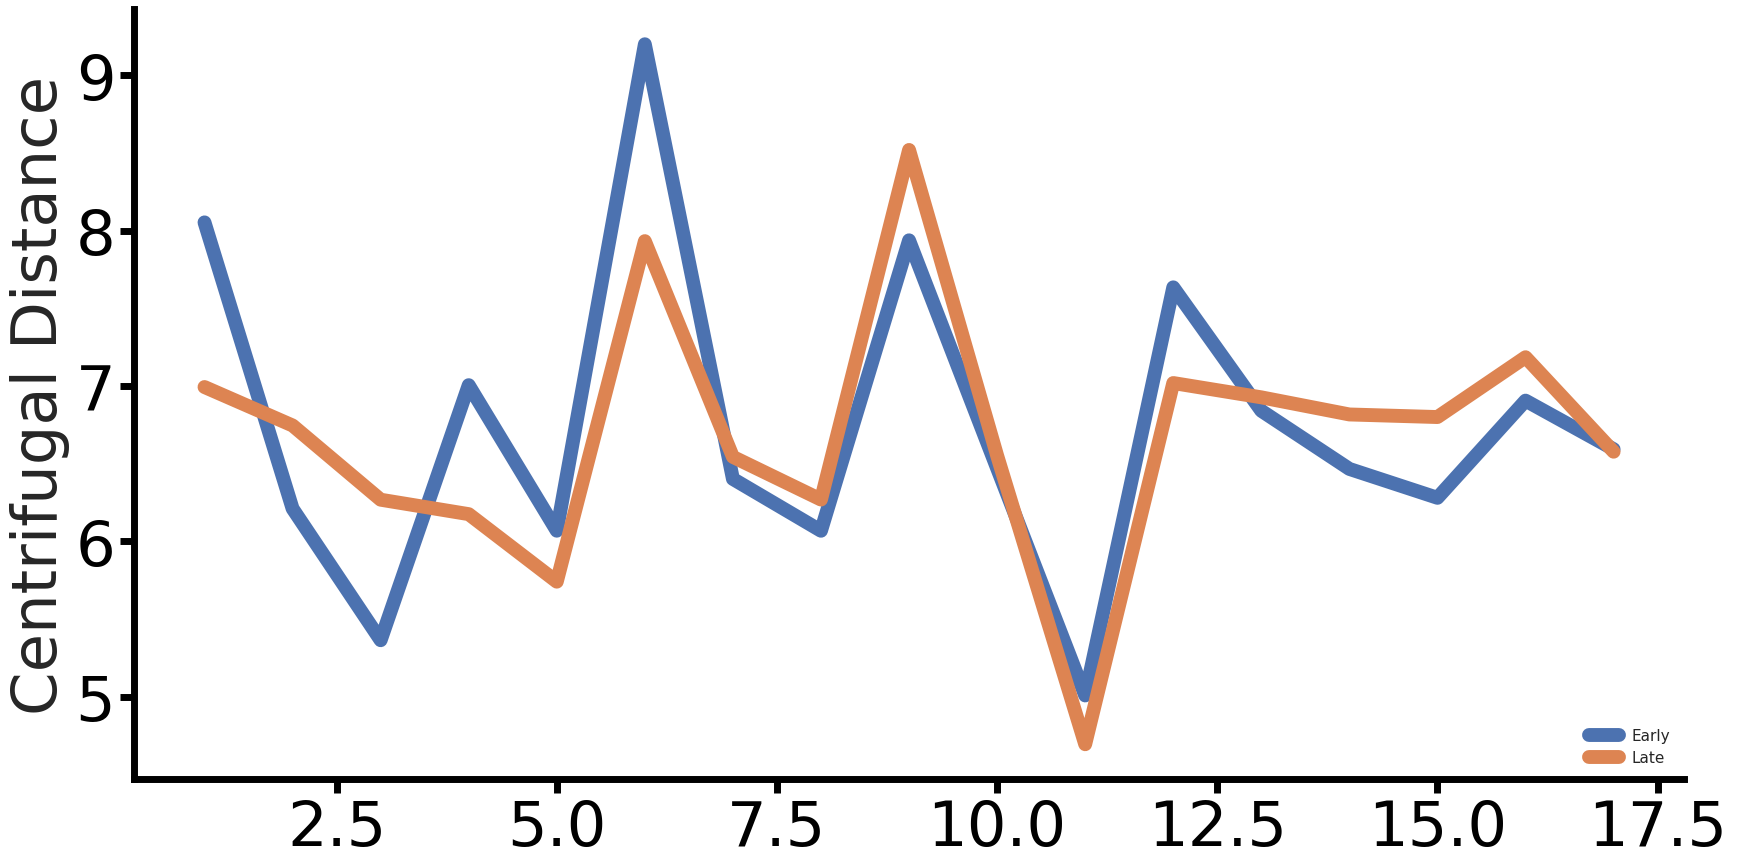

In [10]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')

import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

result = {
    'Early': centrifugal_distance(pseudo_time_3D['Early(MBP)']),
    'Late': centrifugal_distance(pseudo_time_3D['Late(MBP)'])
}
    
set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

x = list(range(1, len(result['Early'])+1))
for key in result.keys():
    plt.plot(x, result[key], label=key, linewidth=figure_size['small'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.legend(
    facecolor='white', loc='lower right'
).get_frame().set_linewidth(0.0)

plt.ylabel("Centrifugal Distance", fontsize=figure_size['ultra'])

plt.show()

In [11]:
def distance_matrix(points):
    _len = len(points)
    result = np.zeros((_len, _len))
    for i in range(_len):
        for j in range(_len):
            result[i, j] = np.linalg.norm(points[i] - points[j])
    return result

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if title:
        plt.savefig(
            '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()